In [171]:
# Analyze nanopore read distributions
# -- total number of reads for the run, and number of mapped reads.
# -- distribution of read counts.
# -- how many unique library elements observed, and any major skew in theoretical vs. observed distribution.
# -- plot of #of reads vs. #of mutations (theoretical vs. observed)

with open("c9r2-ins.csv") as read_file:
    reads = [x.strip().split(",") for x in read_file.readlines()]

In [177]:
# round 1
cas9_mutations = [("CCG", "CTC"),
                  ("CTG", "TGC"),
                  ("TAC", "CAG"),
                  ("AGC", "CAT", "TGT"),
                  ("AGC", "TGT"),
                  ("TTT", "ACC"),
                  ("CTG", "ACC", "GGA"),
                  ("CTT", "GGA"),
                  ("CTT", "CAG"),
                  ("TTG", "GAC"),
                  ("TTT", "GCC"),
                  ("CTT", "CCC", "GGA"),
                  ("CTG", "GAC"),
                  ("TAC", "AAG", "GGA"),
                  ("CTC", "GGA"),
                  ("ATA", "CAG"),
                  ("CTC", "GCT", "GAG"),
                  ("TAC", "CAG")
                  ]
# round 2
cas9_mutations = [("ACC", "AAT", "GGA"),
                  ("ACC", "CGG"),
                  ("ATG", "CCC"),
                  ("CTG", "GCC", "GGA"),
                  ("AGC", "TGT"),
                  ("TAC", "GAT"),
                  ("ACC", "GAG"),
                  ("TTC", "AAT", "ACA"),
                  ("CGG", "GAA"),
                  ("ATC", "GAC"),
                  ("CAG", "AGA"),
                  ("ATG", "GAC", "CGC"),
                  ("TAC", "GAA"),
                  ("TAC", "GAA"),
                  ("GTG", "AGC"),
                  ("GTG", "AAA"),
                  ("GTG", "GAA"),
                  ("CTG", "AAT"),
                  ("CTG", "AAA")]

cas9_mutations_flipped_3 = [("AAT", "GGA", "ACC"),
                          ("CGG", "ACC"),
                          ("CCC", "ATG"),
                          ("CTG", "GCC", "GGA"),
                          ("AGC", "TGT"),
                          ("TAC", "GAT"),
                          ("ACC", "GAG"),
                          ("TTC", "AAT", "ACA"),
                          ("CGG", "GAA"),
                          ("ATC", "GAC"),
                          ("CAG", "AGA"),
                          ("ATG", "GAC", "CGC"),
                          ("TAC", "GAA"),
                          ("TAC", "GAA"),
                          ("GTG", "AGC"),
                          ("GTG", "AAA"),
                          ("GTG", "GAA"),
                          ("CTG", "AAT"),
                          ("CTG", "AAA")]

#cas9_mutations = cas9_mutations_flipped_3

In [178]:
unique_reads = set()
for r in reads:
    unique_reads.add(r[0])
len(unique_reads)

23979

In [179]:
from itertools import product as iter_product
from random import randint
from collections import Counter

element_counts = {item: 0 for item in iter_product(*(range(len(i)) for i in cas9_mutations))}
        # Remove library elements with double mutant at position 8/9
for key in list(element_counts.keys()):
    #if key[7] == 1 and key[8] == 1:
    #    del element_counts[key]
    
    if key[4] == 1 and key[5] == 1:
        del element_counts[key]
    elif key[15] == 1 and key[16] == 1:
        del element_counts[key]

len(element_counts)

1492992

In [180]:
def calc_distances(codon, mutations):
    distances = []
    for item in mutations:
        score = 0
        for i, letter in enumerate(codon):
            if letter not in "ATGC":
                pass
            elif letter == item[i]:
                score += 1
            elif letter != item[i]:
                score -= 1
        distances.append(score)
    return distances

In [185]:
gaps = list()
ambi = list()
good = list()
names = list()
unknown = dict()
last_name = ""

for read in reads:
    name = read[0]
    if name == last_name:
        name += '-alt'
    #names.append(name)
    genotype = list()
    assert len(read[1:]) == len(cas9_mutations)
    
    for j, codon in enumerate(read[1:]):
        if codon in ("", "---", "\n"):
            mutation_id = '9'
        else:
            distances = calc_distances(codon, cas9_mutations[j])
            if distances.count(max(distances)) == 1:  # One best match
            #if max(distances) == 3:  # perfect match
                mutation_id = max(range(len(distances)), key=distances.__getitem__)
            else:  # Multiple equal scores
                mutation_id = '8'
        genotype.append(mutation_id)
    
    if genotype.count('9') == 1:
        idx = genotype.index('9')
        genotype[idx] = randint(0,len(cas9_mutations[idx])-1)
    if genotype.count('8') == 1:
        idx = genotype.index('8')
        genotype[idx] = randint(0,len(cas9_mutations[idx])-1)
    
    if '9' in genotype:
        gaps.append(genotype.count('9'))
    elif '8' in genotype:
        ambi.append(genotype.count('8'))
    else:
        try:
            element_counts[tuple(genotype)] += 1
            good.append(''.join(map(str,genotype)))
        except KeyError:
            unknown[name] = ''.join(map(str,genotype))
    last_name = name

In [186]:
print(f'Good: {len(good)}, Ambiguous: {len(ambi)+len(unknown)}, Gaps: {len(gaps)},')

Good: 7067, Ambiguous: 6136, Gaps: 14307,


In [187]:
1258775 - (304887 + 495425)

458463

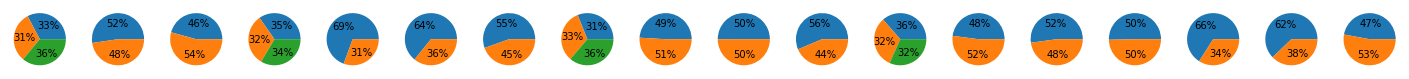

In [188]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=18, sharey=True, figsize=(25,20))

dists = []

for i in range(18):
    dist = [0]*len(cas9_mutations[i])
    for genotype in good:
        if genotype != '000000000000000000':
            dist[int(genotype[i])] += 1
    dists.append(dist)
    axes[i].pie(dist, autopct='%.0f%%')

In [198]:
twos = []
threes = []

two_idx = [1,2,6,8,9,10,12,13,14,17]

for i in range(len(dists)):
    if i in two_idx:
        twos.append(dists[i])
    else:
        threes.append(dists[i])

In [199]:
two_props = [x[1]/(x[0]+x[1]) for x in twos]
three_props = [x[1]/(x[0]+x[1]) for x in threes]

In [200]:
import numpy as np
print(np.mean(two_props), np.mean(three_props))

0.49356162445167684 0.4158778838837499


In [189]:
final_dist = Counter(good)
print(len(final_dist))
final_dist.most_common(200)

7042


[('2110011211011000100', 2),
 ('2110001001021010001', 2),
 ('1011011210010100010', 2),
 ('2010100210021110111', 2),
 ('1001011011001101001', 2),
 ('0010000111011111001', 2),
 ('0112000200011010010', 2),
 ('2111011010011011000', 2),
 ('0110000211121100110', 2),
 ('2110011211100000111', 2),
 ('0102011011100111000', 2),
 ('0012101001021110110', 2),
 ('1101100211010011010', 2),
 ('0000000000121100010', 2),
 ('2010100200001101011', 2),
 ('1012011201010010010', 2),
 ('2111100110020000101', 2),
 ('1011010010121100101', 2),
 ('0012011100001111010', 2),
 ('2101100110020001000', 2),
 ('0012010010021100000', 2),
 ('0101011110011000111', 2),
 ('2112000211020011000', 2),
 ('2001000100110000000', 2),
 ('2110010011021001000', 2),
 ('2001011211021100001', 1),
 ('1011100011011001011', 1),
 ('2100001100000111011', 1),
 ('0010010011101000001', 1),
 ('1002001110011001001', 1),
 ('2110000011100111010', 1),
 ('2102100201001010111', 1),
 ('2001101200000101000', 1),
 ('1011010001100011010', 1),
 ('10011011000

In [190]:
with open("c9r2-ins_counts.csv", mode='w') as outfile:
    for item in element_counts:
        if item[7] == 0 or item[8] == 0:
            print("".join(map(str, item)), element_counts[item], sep=',', file=outfile)

In [191]:
sum([element_counts[item] > 0 for item in element_counts])

7233

In [87]:
freq_post = {k: final_dist[k]/len(good) for k in final_dist}
freq_pre = {k: pre_final_dist[k]/sum(pre_final_dist.values()) for k in final_dist}

NameError: name 'pre_final_dist' is not defined

In [465]:
with open("hits_r2.csv",  mode='w') as outfile:
    print("genotype,pre_freq,pre_n,post_freq,post_n,fold_change", file=outfile)
    for k in freq_pre:
        #k = "".join(map(str, item))
        pre = True
        post = True
        try:
            pre_n = pre_final_dist[k]
            pre_freq = freq_pre[k]
        except KeyError:
            pre_n = 0
            pre_freq = 0
            pre = False
        try:
            post_freq = freq_post[k]
            post_n = final_dist[k]
        except KeyError:
            post_freq = 0
            post_n = 0
            post = False
        if not pre:
            change = 'nan'
        elif not post:
            change = 0
        else:
            try:
                change = freq_post[k]/freq_pre[k]
            except ZeroDivisionError:
                change = 'nan'
        print(f'N-{k}', pre_freq, pre_n, post_freq, post_n, change, sep=',', file=outfile)

#change = {k: (freq_post[k]-freq_pre[k])/(freq_pre[k]+10**-8) for k in freq_post}
#change

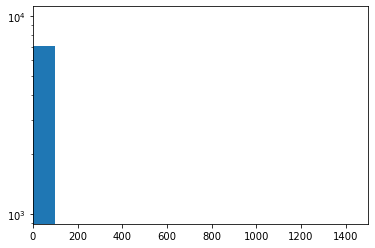

In [201]:
plt.hist(final_dist.values(), bins=[1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500])
plt.yscale('log', nonpositive='clip')
#plt.xscale('log', nonposx='clip')
plt.xlim((0,1500))
plt.show()

In [203]:
dist_values = list(sorted(final_dist.values(), reverse=True))
for i in range(150):
    dist_values[i] *= 0.1

<ipython-input-204-23caeed00424>:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((0,10**3.5))


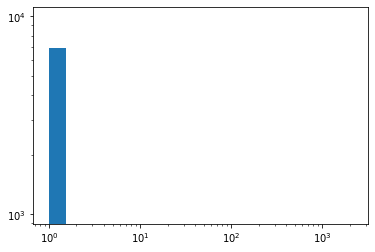

In [204]:
import numpy as np

plt.hist(dist_values, bins=np.logspace(0,3.5,20))
plt.yscale('log')
plt.xscale('log')
plt.xlim((0,10**3.5))
#plt.ylim((0,400000))
plt.show()

In [192]:
from random import choice

options = list(element_counts.keys())
sub_options = options[:1490000]
n = len(good)
theo = [choice(options) for i in range(n)]
theo_dist = Counter(theo)

theo_dist.most_common(5)

[((2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1), 2),
 ((2, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1), 2),
 ((2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0), 2),
 ((2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1), 2),
 ((2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1), 2)]

<ipython-input-205-3a7348df48f4>:4: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((0,10**3.5))


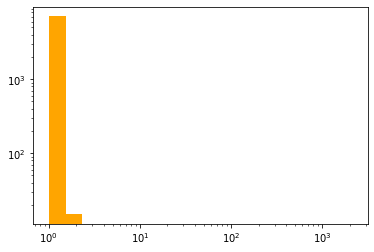

In [205]:
plt.hist(theo_dist.values(), bins=np.logspace(0,3.5,20), color='orange')
plt.yscale('log')
plt.xscale('log')
plt.xlim((0,10**3.5))
#plt.ylim((0,400000))
plt.show()

In [193]:
number_data = Counter([sum([x != '0' for x in y]) for y in good])
sum(number_data.values())
theo_number = Counter([sum([x != 0 for x in y]) for y in theo])

In [135]:
number_data[0] -= 3800/5
number_data[1] -= 3200/5
number_data[2] -= 1200/5
number_data[3] -= 500/5
number_data[4] -= 100/5
for i in range(5,18):
    number_data[i] = round(number_data[i] * (1.25), 0)

sum(number_data.values())

23656.0

In [194]:
number_data

Counter({11: 1016,
         9: 1363,
         7: 669,
         10: 1359,
         12: 638,
         5: 129,
         14: 94,
         8: 1061,
         13: 330,
         6: 326,
         4: 35,
         15: 31,
         2: 3,
         3: 9,
         16: 4})

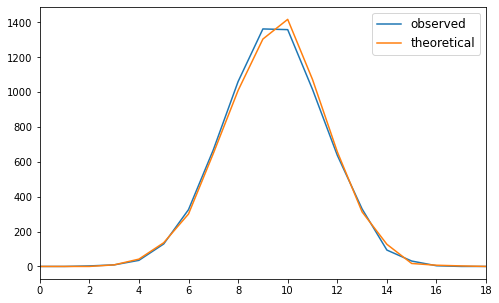

In [195]:
x = range(19)
y = [number_data[i] for i in x]
theo_y = [theo_number[i] for i in x]

fig, ax = plt.subplots(figsize=(8,5))

plt.plot(x, y)
plt.plot(x, theo_y)
plt.legend(labels=("observed", "theoretical"), fontsize='large')
plt.xlim((0,18))
plt.show()

In [381]:
plt.legend?

In [196]:
import itertools

block_data = []
element_counts = final_dist

block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[:3])):
    point = sum([element_counts[x] for x in element_counts if x[:3]=="".join(map(str, item))])
    block_data[0].append(point)
    print(f"block1: {item}", point)
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[3:6])):
    point = sum([element_counts[x] for x in element_counts if x[3:6]=="".join(map(str, item))])
    block_data[1].append(point)
    print(f"block2: {item}", point)
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[6:8])):
    point = sum([element_counts[x] for x in element_counts if x[6:8]=="".join(map(str, item))])
    block_data[2].append(point)
    print(f"block3: {item}", point)
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[8:10])):
    point = sum([element_counts[x] for x in element_counts if x[8:10]=="".join(map(str, item))])
    if item not in []:
        block_data[3].append(point)
        print(f"block4: {item}", sum([element_counts[x] for x in element_counts if x[8:10]=="".join(map(str, item))]))
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[10:12])):
    point = sum([element_counts[x] for x in element_counts if x[10:12]=="".join(map(str, item))])
    block_data[4].append(point)
    print(f"block5: {item}", point)
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[12:14])):
    point = sum([element_counts[x] for x in element_counts if x[12:14]=="".join(map(str, item))])
    block_data[5].append(point)
    print(f"block6: {item}", point)
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[14:17])):
    point = sum([element_counts[x] for x in element_counts if x[14:17]=="".join(map(str, item))])
    block_data[6].append(point)
    print(f"block7: {item}", point)
print()
block_data.append(list())
for item in itertools.product(*(range(len(i)) for i in cas9_mutations[17:])):
    point = sum([element_counts[x] for x in element_counts if x[17:]=="".join(map(str, item))])
    block_data[7].append(point)
    print(f"block8: {item}", point)
print()
print(f"Total mutants detected: {len(final_dist)}")

block1: (0, 0, 0) 512
block1: (0, 0, 1) 646
block1: (0, 1, 0) 532
block1: (0, 1, 1) 624
block1: (1, 0, 0) 530
block1: (1, 0, 1) 701
block1: (1, 1, 0) 477
block1: (1, 1, 1) 501
block1: (2, 0, 0) 585
block1: (2, 0, 1) 723
block1: (2, 1, 0) 595
block1: (2, 1, 1) 641

block2: (0, 0, 0) 832
block2: (0, 0, 1) 879
block2: (0, 1, 0) 744
block2: (0, 1, 1) 0
block2: (1, 0, 0) 705
block2: (1, 0, 1) 834
block2: (1, 1, 0) 705
block2: (1, 1, 1) 0
block2: (2, 0, 0) 838
block2: (2, 0, 1) 817
block2: (2, 1, 0) 713
block2: (2, 1, 1) 0

block3: (0, 0) 1251
block3: (0, 1) 1269
block3: (0, 2) 1399
block3: (1, 0) 947
block3: (1, 1) 1039
block3: (1, 2) 1162

block4: (0, 0) 1749
block4: (0, 1) 1719
block4: (1, 0) 1786
block4: (1, 1) 1813

block5: (0, 0) 1504
block5: (0, 1) 1263
block5: (0, 2) 1215
block5: (1, 0) 1074
block5: (1, 1) 989
block5: (1, 2) 1022

block6: (0, 0) 1709
block6: (0, 1) 1679
block6: (1, 0) 1977
block6: (1, 1) 1702

block7: (0, 0, 0) 1068
block7: (0, 0, 1) 1297
block7: (0, 1, 0) 1191
block

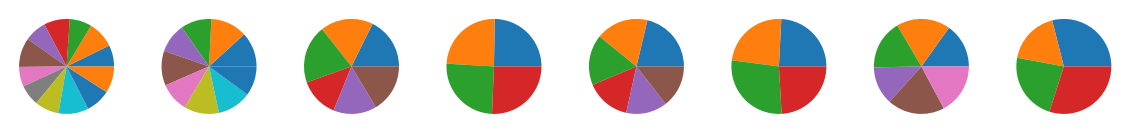

In [197]:
fig, axes = plt.subplots(nrows=1,ncols=8,figsize=(20,10))
for i, block in enumerate(block_data):
    axes[i].pie(block)

([<matplotlib.patches.Wedge at 0x7fd2b390d040>,
 [Text(0.03455180204558485, 1.0994572174374968, ''),
  Text(-0.03455180204558498, -1.0994572174374968, '')])

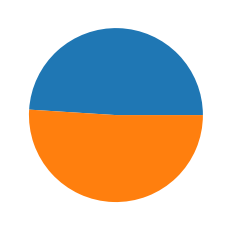

In [466]:
plt.pie([49,51])

In [390]:
pre_final_dist = final_dist

In [410]:
pre_final_dist['000000000000000000']

22997

In [154]:
ls

1k-mutations.csv                  LV2-C9lib.fasta
C9-1k.paf                         LV2-cas9-n-reference.fasta
C9-r2-ref.fasta                   LV2-mutant-cas9-reference.fasta
C9LE3-mini-mutant-mutations.csv   Untitled.ipynb
C9LE3-mini-mutant.paf             Untitled1.ipynb
C9LE3-mini-mutant_count-file.csv  __pycache__/
C9LE3-mini-n-mutations.csv        all_elements_r1.csv
C9LE3-mini-n_count-file.csv       cs-align-tests/
C9LE3_count_file.csv              hits.csv
C9LE3_perfect_count_file.csv      hits_r1-x.xlsx
C9r2-pre-N.paf                    hits_r1.csv
C9r2-pre.paf                      hits_r2.csv
Cas9-post-r1-mutations.csv        main.py
Cas9-post-r1-n-1.paf              mini_n.paf
Cas9-post-r1-n-mutations.csv      minion_hits-1a.csv
Cas9-post-r1-n_count-file.csv     minion_hits.csv
Cas9-post-r1.paf                  post/
Cas9-post-r1_count-file.csv       pre-1a.csv
Cas9-post-r2-mutations.csv        pre-counts-1a.csv
Cas9-post-r2-n-1.paf              pre-r2a.csv
Cas9-post-r2-n-m

In [157]:
with open("pre-r2a_r1muts_counts.csv") as infile:
    data = infile.readlines()
    
counts = {x.split(",")[0]: int(x.split(",")[1]) for x in data}

In [170]:
{k: counts[k] for k in counts if counts[k]>10}

{'001010101002101010': 52,
 '001010101002121010': 52,
 '001210101002101010': 18,
 '001210101002121010': 22,
 '100000001000000010': 92,
 '100000001000001010': 40,
 '100000001000100010': 17,
 '100000001000101010': 14,
 '100000001002000010': 17,
 '100000101000000010': 17,
 '100010101002101010': 18,
 '100010101002121010': 34,
 '100210101002101010': 11,
 '100210101002121010': 11,
 '101000001000000010': 12,
 '101000101002101010': 46,
 '101000101002121010': 52,
 '101010100002101010': 39,
 '101010100002121010': 35,
 '101010101000000010': 27,
 '101010101000101010': 11,
 '101010101002000010': 28,
 '101010101002001010': 30,
 '101010101002021010': 18,
 '101010101002100010': 148,
 '101010101002101000': 28,
 '101010101002101010': 9145,
 '101010101002101011': 30,
 '101010101002101020': 26,
 '101010101002111010': 776,
 '101010101002120010': 56,
 '101010101002121000': 23,
 '101010101002121010': 9634,
 '101010101002121011': 25,
 '101010101002121020': 25,
 '101010101012101010': 81,
 '101010101012121010':

In [3]:
import pandas as pd
pd.DataFrame(index=list("asdf"), columns=list("asdf"))

,a,s,d,f
a,NaN,NaN,NaN,NaN
s,NaN,NaN,NaN,NaN
d,NaN,NaN,NaN,NaN
f,NaN,NaN,NaN,NaN


In [2]:
list("asdf")

['a', 's', 'd', 'f']